<a href="https://colab.research.google.com/github/ivansantoscoy/Proyectos-Python-Jupyter-Google-Colab-/blob/main/analisis_checadas_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bloque 0 – Introducción y diccionario de columnas

Este cuaderno analiza errores de checada para determinar si los patrones observados sugieren mayor probabilidad de error humano o falla de sistema.

El flujo incluye:
- Limpieza de datos
- Estadística (Poisson/U-Chart)
- Pareto
- Clustering
- Cruces por torniquete/turno
- Cruces extendidos
- PCA opcional
- Resumen interpretativo de la hipótesis

**Diccionario del dataset normalizado:**
- `fecha`: Día del evento.
- `dia_semana`: Día de la semana derivado de `fecha`.
- `turno`: Turno operativo (1=matutino, 3=nocturno, etc.).
- `empresa`: Código extraído de `Trabajador` (47 o 506).
- `torniquete`: 1 o 2 cuando es físico; 0 cuando se asigna manualmente (pareja manual en ambos lados).
- `entradas`: Número de checadas válidas (swipes) en torniquete 1/2.
- `empleados_unicos`: Personas distintas registradas.
- `manual_parcial`: Entrada o salida manual, la otra en torniquete (pareja completa con un lado manual).
- `manual_ambos`: Entrada y salida manual (pareja completa, ambos lados manuales).
- `anomalia_incompleta`: Falta de entrada o salida (no hay pareja completa).
- `manuales`: Suma de manual_parcial + manual_ambos.
- `anomalias`: Alias de `anomalia_incompleta`.
- `justificados`: Casos con terminal vacía y concepto (VAC, FJ, SUS). Informativo, no es error.
- `errores`: Total de errores (manual_parcial + manual_ambos + anomalia_incompleta).
- `errores_por_empleado`: Errores / empleados únicos.


## Preparación (librerías y función para títulos de gráficos)

In [1]:
import sys, subprocess

def _ensure(pkg):
    try:
        __import__(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "--quiet"])

for p in ["pandas","numpy","xlsxwriter","scipy","scikit-learn","matplotlib"]:
    _ensure(p)

import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

FORCE_DELIMITER = None
DATE_KWARGS = dict(errors="coerce", dayfirst=False)  # mm/dd/yyyy
N_CLUSTERS = 3

def show_with_spaced_title(title):
    plt.tight_layout()
    plt.show()
    print("\n\n" + title)  # 2 renglones en blanco y título en el tercero


## Input de archivo

In [2]:
FILE_PATH = input("Escribe el nombre del archivo CSV (ej. datos.csv): ").strip()
print("Usando archivo:", FILE_PATH)

Escribe el nombre del archivo CSV (ej. datos.csv): Chec 2025.csv
Usando archivo: Chec 2025.csv


## Funciones auxiliares (detección de encabezado, mapeo de columnas y clasificación neutral)

In [3]:
import re

def detect_header_row_and_delimiter(path, search_limit=200, force_delim=None):
    with open(path, "r", encoding="latin1") as f:
        lines = f.readlines()
    header_candidates = []
    for i, line in enumerate(lines[:search_limit]):
        lower = line.lower()
        if all(k in lower for k in ["empresa","trabajador","fecha","checada","turno","terminal"]):
            header_candidates.append(i)
    header_row = header_candidates[0] if header_candidates else None
    if force_delim:
        delim = force_delim
    else:
        try:
            seg = "".join(lines[(header_row or 0): (header_row or 0) + 5])
            delim = csv.Sniffer().sniff(seg).delimiter
        except Exception:
            delim = ","
    return header_row, delim

def pick(colnames, *aliases):
    colnames = [str(c) for c in colnames]
    for a in aliases:
        if a in colnames: return a
    simp = {c.lower().replace(" ","").replace("á","a").replace("é","e").replace("í","i").replace("ó","o").replace("ú","u"): c for c in colnames}
    for a in aliases:
        key = a.lower().replace(" ","").replace("á","a").replace("é","e").replace("í","i").replace("ó","o").replace("ú","u")
        if key in simp: return simp[key]
    return None

def simplify_tipo(s):
    t = s.astype(str).str.lower()
    return np.where(t.str.contains("entrada"), "Entrada",
           np.where(t.str.contains("salida"), "Salida", ""))

def split_empresa_empleado(trabajador):
    tr = trabajador.astype(str).str.strip()
    empresa = np.where(tr.str.startswith("47"), "47", np.where(tr.str.startswith("506"), "506", "NA"))
    empleado_id = tr.str.replace(r"^(47|506)", "", regex=True)
    return empresa, empleado_id

def base_flags(df):
    df["is_valid_swipe"] = df["torniquete"].isin([1,2]) & df["tipo_simpl"].isin(["Entrada","Salida"])
    df["is_manual"] = df["torniquete"].fillna(-999).astype(int).eq(0)
    return df

def classify_neutral(group):
    is_e_val = ((group["tipo_simpl"]=="Entrada") & group["is_valid_swipe"]).any()
    is_s_val = ((group["tipo_simpl"]=="Salida")  & group["is_valid_swipe"]).any()
    is_e_man = ((group["tipo_simpl"]=="Entrada") & group["is_manual"]).any()
    is_s_man = ((group["tipo_simpl"]=="Salida")  & group["is_manual"]).any()

    e_terms = group.loc[(group["tipo_simpl"]=="Entrada") & group["is_valid_swipe"], "torniquete"].dropna().unique()
    s_terms = group.loc[(group["tipo_simpl"]=="Salida")  & group["is_valid_swipe"], "torniquete"].dropna().unique()

    pair_complete = ((is_e_val or is_e_man) and (is_s_val or is_s_man))

    manual_parcial = 0
    manual_ambos = 0
    anomalia_incompleta = 0
    tor_attr = 0

    if pair_complete:
        if is_e_man and is_s_man:
            manual_ambos = 1
            tor_attr = 0
        elif is_e_man and is_s_val:
            manual_parcial = 1
            tor_attr = int(s_terms[0]) if len(s_terms)>0 else 0
        elif is_s_man and is_e_val:
            manual_parcial = 1
            tor_attr = int(e_terms[0]) if len(e_terms)>0 else 0
        else:
            tor_attr = int(e_terms[0]) if len(e_terms)>0 else (int(s_terms[0]) if len(s_terms)>0 else 0)
    else:
        anomalia_incompleta = 1
        any_terms = np.concatenate([e_terms, s_terms])
        tor_attr = int(any_terms[0]) if any_terms.size>0 else 0

    return pd.Series({"manual_parcial": manual_parcial,
                      "manual_ambos": manual_ambos,
                      "anomalia_incompleta": anomalia_incompleta,
                      "torniquete_attr": tor_attr})


# Bloque 1 – Limpieza y normalización

- Detecta encabezados y delimitador.
- Interpreta fechas en mm/dd/aaaa.
- Separa empresa y empleado.
- Clasificación neutral: `manual_parcial`, `manual_ambos`, `anomalia_incompleta`.
- Agregación por día–turno–torniquete–empresa.
- Exportación opcional a CSV/XLSX (comentado).


In [4]:
header_row, delim = detect_header_row_and_delimiter(FILE_PATH, force_delim=FORCE_DELIMITER)
if header_row is None:
    df_raw = pd.read_csv(FILE_PATH, encoding="latin1", sep=(delim or ","), on_bad_lines="skip")
else:
    df_raw = pd.read_csv(FILE_PATH, encoding="latin1", sep=(delim or ","), header=header_row, on_bad_lines="skip")
df_raw.columns = [str(c).strip() for c in df_raw.columns]

cols = df_raw.columns.tolist()
col_trabajador  = pick(cols, "Trabajador","trabajador","num empleado","empleado")
col_fecha       = pick(cols, "Fecha","fecha")
col_checada     = pick(cols, "Checada","checada","FechaHora","fechahora")
col_tipo        = pick(cols, "TipoRegistro","tipo registro","tiporegistro","tipo")
col_turno       = pick(cols, "Turno","turno")
col_terminal    = pick(cols, "Terminal","terminal")
col_concepto    = pick(cols, "Concepto","concepto","Motivo","motivo")

use_cols = [c for c in [col_trabajador, col_fecha, col_checada, col_tipo, col_turno, col_terminal, col_concepto] if c is not None]
df = df_raw[use_cols].copy()

if col_fecha in df.columns:
    df["fecha"] = pd.to_datetime(df[col_fecha], **DATE_KWARGS).dt.date
else:
    df["fecha"] = pd.to_datetime(df[col_checada], **DATE_KWARGS).dt.date

if col_checada in df.columns:
    df["checada_dt"] = pd.to_datetime(df[col_checada], **DATE_KWARGS)
else:
    df["checada_dt"] = pd.NaT

if col_turno in df.columns:
    df["turno"] = (df[col_turno].astype(str).str.extract(r"(\d+)")[0].astype(float).astype("Int64"))
else:
    df["turno"] = pd.NA

if col_terminal in df.columns:
    df["terminal_raw"] = df[col_terminal].astype(str).str.strip()
    df["torniquete"] = pd.to_numeric(df["terminal_raw"].replace({"": np.nan}), errors="coerce")
else:
    df["torniquete"] = np.nan

if col_concepto in df.columns:
    df["concepto"] = df[col_concepto].astype(str).str.strip()
else:
    df["concepto"] = ""

if col_tipo in df.columns:
    df["tipo_simpl"] = simplify_tipo(df[col_tipo])
else:
    df["tipo_simpl"] = ""

if col_trabajador in df.columns:
    df["empresa"], df["empleado_id"] = split_empresa_empleado(df[col_trabajador])
else:
    df["empresa"] = "NA"
    df["empleado_id"] = ""

df = base_flags(df)

par = (df.groupby(["fecha","empresa","empleado_id","turno"], dropna=False)
         .apply(classify_neutral)
         .reset_index())

entradas = (df.loc[df["is_valid_swipe"]]
              .groupby(["fecha","turno","torniquete","empresa"], dropna=False)
              .agg(entradas=("empleado_id","count"),
                   empleados_unicos=("empleado_id","nunique"))
              .reset_index())

mp = (par[par["manual_parcial"]==1]
      .groupby(["fecha","turno","empresa","torniquete_attr"])
      .size().rename("manual_parcial").reset_index().rename(columns={"torniquete_attr":"torniquete"}))

ma = (par[par["manual_ambos"]==1]
      .assign(torniquete_attr=0)
      .groupby(["fecha","turno","empresa","torniquete_attr"])
      .size().rename("manual_ambos").reset_index().rename(columns={"torniquete_attr":"torniquete"}))

an = (par[par["anomalia_incompleta"]==1]
      .groupby(["fecha","turno","empresa","torniquete_attr"])
      .size().rename("anomalia_incompleta").reset_index().rename(columns={"torniquete_attr":"torniquete"}))

from functools import reduce
componentes = [entradas, mp, ma, an]
base = reduce(lambda a,b: pd.merge(a,b, on=["fecha","turno","torniquete","empresa"], how="outer"), componentes)

for c in ["entradas","empleados_unicos","manual_parcial","manual_ambos","anomalia_incompleta"]:
    if c not in base.columns: base[c] = 0
base[["entradas","empleados_unicos","manual_parcial","manual_ambos","anomalia_incompleta"]] =     base[["entradas","empleados_unicos","manual_parcial","manual_ambos","anomalia_incompleta"]].fillna(0).astype(int)

justificados = (df.loc[df["torniquete"].isna() & df["concepto"].ne("")]
                  .groupby(["fecha","turno","empresa"], dropna=False)
                  .agg(justificados=("empleado_id","count"))
                  .reset_index())
base = base.merge(justificados, on=["fecha","turno","empresa"], how="left")
base["justificados"] = base["justificados"].fillna(0).astype(int)

base["manuales"] = base["manual_parcial"] + base["manual_ambos"]
base["anomalias"] = base["anomalia_incompleta"]
base["errores"] = base[["manual_parcial","manual_ambos","anomalia_incompleta"]].sum(axis=1)
base["errores_por_empleado"] = np.where(base["empleados_unicos"]>0, base["errores"]/base["empleados_unicos"], np.nan)
base["dia_semana"] = pd.to_datetime(base["fecha"]).dt.day_name()

final_cols = ["fecha","dia_semana","turno","empresa","torniquete",
              "entradas","empleados_unicos",
              "manual_parcial","manual_ambos","anomalia_incompleta",
              "manuales","anomalias","justificados","errores","errores_por_empleado"]
base = base[final_cols].sort_values(["fecha","turno","empresa","torniquete"])

print("Preview normalizado:")
print(base.head(10))

# Exportación opcional:
# base.to_csv("dataset_normalizado_turnos_torniquetes.csv", index=False, encoding="utf-8")
# with pd.ExcelWriter("dataset_normalizado_turnos_torniquetes.xlsx", engine="xlsxwriter") as writer:
#     base.to_excel(writer, index=False, sheet_name="Datos")


/tmp/ipython-input-1193833775.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(FILE_PATH, encoding="latin1", sep=(delim or ","), header=header_row, on_bad_lines="skip")
/tmp/ipython-input-1193833775.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(classify_neutral)


Preview normalizado:
         fecha dia_semana  turno empresa  torniquete  entradas  \
0   2025-01-01  Wednesday      3      47         0.0         0   
1   2025-01-04   Saturday      1      47         0.0         0   
3   2025-01-04   Saturday      1      47         1.0       487   
5   2025-01-04   Saturday      1      47         2.0       526   
2   2025-01-04   Saturday      1     506         0.0         0   
4   2025-01-04   Saturday      1     506         1.0        63   
6   2025-01-04   Saturday      1     506         2.0        69   
7   2025-01-04   Saturday      3      47         0.0         0   
8   2025-01-04   Saturday      3      47         1.0       230   
10  2025-01-04   Saturday      3      47         2.0       212   

    empleados_unicos  manual_parcial  manual_ambos  anomalia_incompleta  \
0                  0               0             0                    2   
1                  0               0            15                    3   
3                431       

# Bloque 2 – Exploración inicial

Exploramos errores totales por día para una visión general de la variabilidad.


Errores totales por día:
         fecha  errores
0   2025-01-01        2
1   2025-01-04       90
2   2025-01-05        5
3   2025-01-07      106
4   2025-01-08       78
..         ...      ...
71  2025-12-03       63
72  2025-12-05       70
73  2025-12-06       79
74  2025-12-08       75
75  2025-12-09       88

[76 rows x 2 columns]


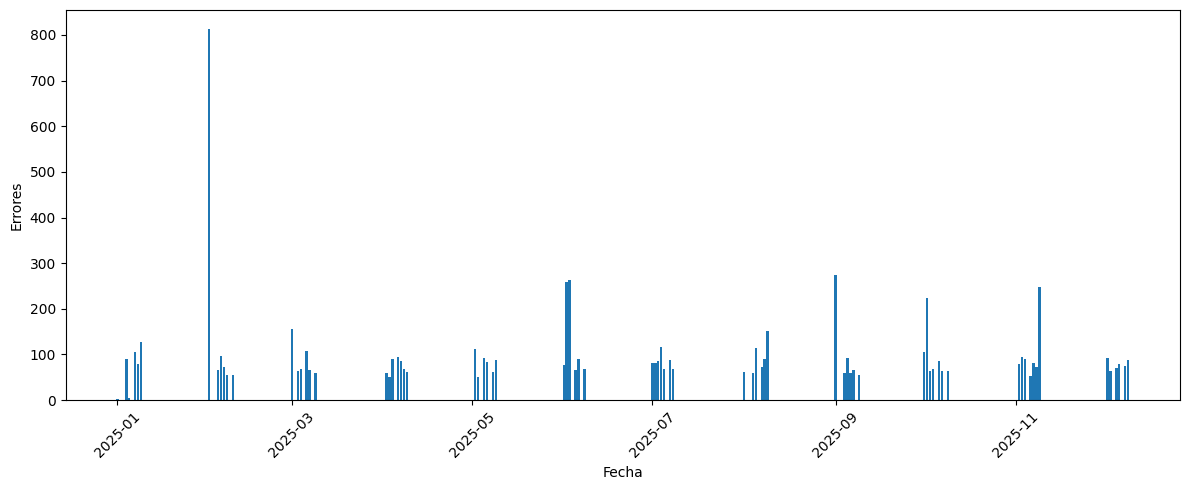



Errores por día


In [5]:
df = base.copy()
resumen_dia = df.groupby("fecha")["errores"].sum().reset_index()
print("Errores totales por día:")
print(resumen_dia)

plt.figure(figsize=(12,5))
plt.bar(resumen_dia["fecha"], resumen_dia["errores"])
plt.xticks(rotation=45)
plt.xlabel("Fecha"); plt.ylabel("Errores")
show_with_spaced_title("Errores por día")

# Bloque 3 – Distribución de Poisson y U-Chart

Se compara la distribución observada de errores diarios con una Poisson (λ = media diaria) y se grafica un U-Chart.


Lambda (media diaria de errores) = 98.83


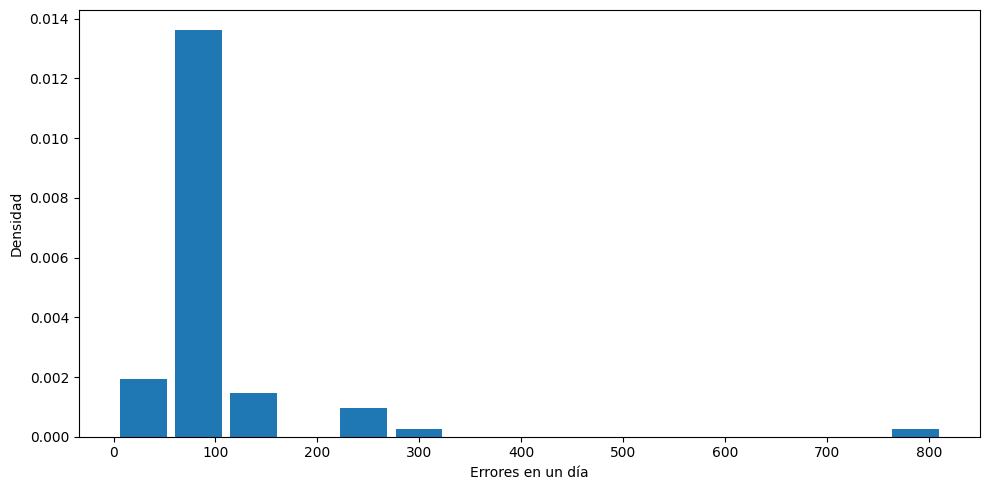



Distribución observada de errores diarios


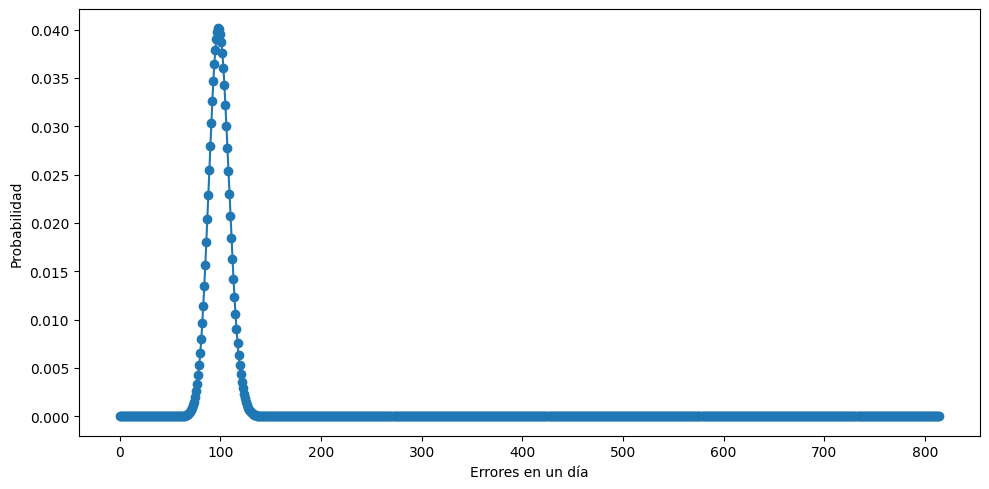



Poisson teórica (λ=98.8)


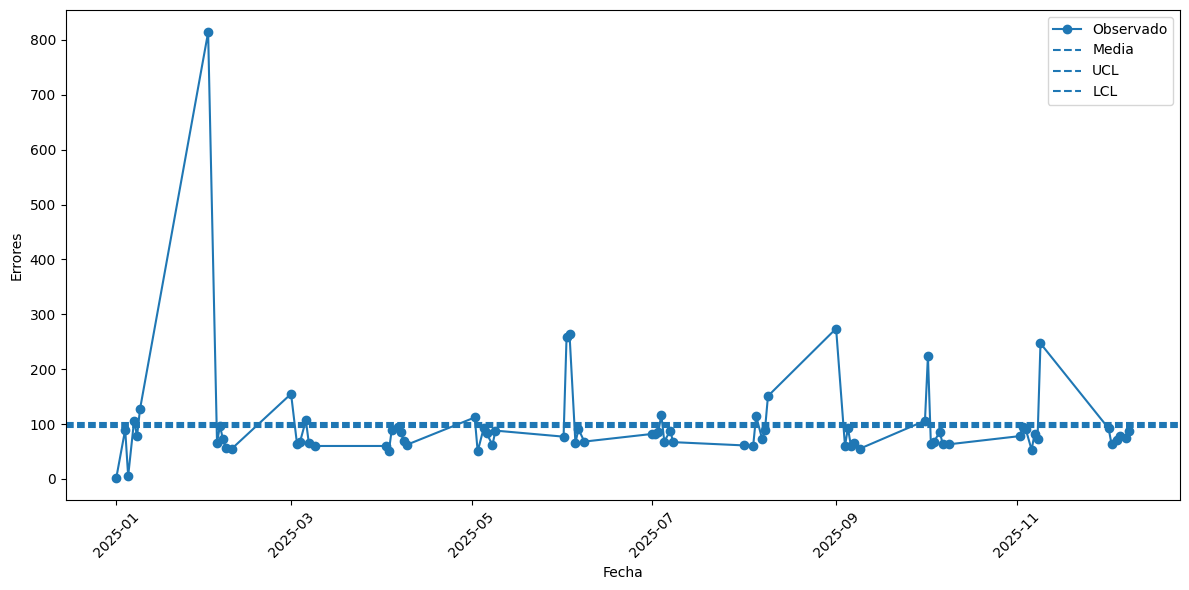



U-Chart de errores diarios


In [6]:
lambda_diario = resumen_dia["errores"].mean()
print(f"Lambda (media diaria de errores) = {lambda_diario:.2f}")

# Histograma observado
plt.figure(figsize=(10,5))
plt.hist(resumen_dia["errores"], bins=15, rwidth=0.85, density=True)
plt.xlabel("Errores en un día"); plt.ylabel("Densidad")
show_with_spaced_title("Distribución observada de errores diarios")

# Poisson teórica
max_error = int(resumen_dia["errores"].max())
x = np.arange(0, max_error+1)
pmf = stats.poisson.pmf(x, lambda_diario)
plt.figure(figsize=(10,5))
plt.plot(x, pmf, "o-")
plt.xlabel("Errores en un día"); plt.ylabel("Probabilidad")
show_with_spaced_title(f"Poisson teórica (λ={lambda_diario:.1f})")

# U-Chart (simplificado)
n = len(resumen_dia)
ucl = lambda_diario + 3*np.sqrt(lambda_diario/n)
lcl = max(0,  lambda_diario - 3*np.sqrt(lambda_diario/n))

plt.figure(figsize=(12,6))
plt.plot(resumen_dia["fecha"], resumen_dia["errores"], marker="o", linestyle="-", label="Observado")
plt.axhline(lambda_diario, linestyle="--", label="Media")
plt.axhline(ucl, linestyle="--", label="UCL")
plt.axhline(lcl, linestyle="--", label="LCL")
plt.xticks(rotation=45); plt.xlabel("Fecha"); plt.ylabel("Errores")
plt.legend()
show_with_spaced_title("U-Chart de errores diarios")

# Bloque 4 – Pareto de causas

Diagrama de Pareto para priorizar el tipo de error que más contribuye.


In [ ]:
causas = {
    "Manual parcial": df["manual_parcial"].sum(),
    "Manual ambos": df["manual_ambos"].sum(),
    "Anomalía incompleta": df["anomalia_incompleta"].sum()
}
df_pareto = pd.DataFrame(list(causas.items()), columns=["Causa","Total"]).sort_values("Total", ascending=False)
print(df_pareto)

df_pareto["Porcentaje"] = df_pareto["Total"] / df_pareto["Total"].sum() * 100
df_pareto["Acumulado"] = df_pareto["Porcentaje"].cumsum()

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.bar(df_pareto["Causa"], df_pareto["Total"])
ax1.set_ylabel("Errores (total)")
ax2 = ax1.twinx()
ax2.plot(df_pareto["Causa"], df_pareto["Acumulado"], marker="o")
ax2.set_ylabel("% Acumulado"); ax2.set_ylim(0,110)
show_with_spaced_title("Pareto de causas de error")

# Bloque 5 – Clustering (KMeans)

Segmentamos días por composición de errores (proporciones). Se anotan centroides (C0, C1, ...) como "tooltips" mínimos.


In [ ]:
df_clust = df.groupby("fecha")[["manual_parcial","manual_ambos","anomalia_incompleta","errores"]].sum().reset_index()
df_clust["p_manual_parcial"]  = df_clust["manual_parcial"] / df_clust["errores"].replace(0,1)
df_clust["p_manual_ambos"]    = df_clust["manual_ambos"]   / df_clust["errores"].replace(0,1)
df_clust["p_anomalia_incomp"] = df_clust["anomalia_incompleta"] / df_clust["errores"].replace(0,1)

X = df_clust[["p_manual_parcial","p_manual_ambos","p_anomalia_incomp"]].fillna(0)
scaler = StandardScaler(); X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
df_clust["cluster"] = kmeans.fit_predict(X_scaled)

print("Cluster asignado por día (primeras filas):")
print(df_clust.head())

# Proyección 2D simple (primeras 2 variables estandarizadas)
x_axis = X_scaled[:,0]  # p_manual_parcial
y_axis = X_scaled[:,1]  # p_manual_ambos
centroids = kmeans.cluster_centers_

plt.figure(figsize=(8,6))
for c in sorted(df_clust["cluster"].unique()):
    subset = df_clust[df_clust["cluster"]==c]
    plt.scatter(x_axis[subset.index], y_axis[subset.index], label=f"Cluster {c}", alpha=0.7)

for i, ctr in enumerate(centroids):
    plt.scatter(ctr[0], ctr[1], marker="X", s=120)
    plt.annotate(f"C{i}", (ctr[0], ctr[1]), textcoords="offset points", xytext=(6,6))

plt.xlabel("p_manual_parcial (estandarizado)")
plt.ylabel("p_manual_ambos (estandarizado)")
plt.legend()
show_with_spaced_title("Clustering de días (centroides anotados)")

# Bloque 5.4–5.8 – Lectura avanzada de clusters

Perfil promedio y cruces por turno, torniquete y empresa. Incluye resumen textual.


In [ ]:
perfil_cluster = (df_clust.groupby("cluster")[["p_manual_parcial","p_manual_ambos","p_anomalia_incomp"]]
                   .mean().reset_index().sort_values("cluster"))
print("Perfil promedio por cluster:")
print(perfil_cluster)

df_clusters_join = df.merge(df_clust[["fecha","cluster"]], on="fecha", how="left")

crosstab_turno = (df_clusters_join.groupby(["cluster","turno"])["errores"].sum()
                  .reset_index().pivot(index="cluster", columns="turno", values="errores").fillna(0))
crosstab_torniquete = (df_clusters_join.groupby(["cluster","torniquete"])["errores"].sum()
                       .reset_index().pivot(index="cluster", columns="torniquete", values="errores").fillna(0))
crosstab_empresa = (df_clusters_join.groupby(["cluster","empresa"])["errores"].sum()
                    .reset_index().pivot(index="cluster", columns="empresa", values="errores").fillna(0))

crosstab_turno.plot(kind="bar", figsize=(8,5))
plt.ylabel("Errores")
show_with_spaced_title("Errores por cluster y turno")

crosstab_torniquete.plot(kind="bar", figsize=(8,5))
plt.ylabel("Errores")
show_with_spaced_title("Errores por cluster y torniquete")

crosstab_empresa.plot(kind="bar", figsize=(8,5))
plt.ylabel("Errores")
show_with_spaced_title("Errores por cluster y empresa")

def resumen_cluster(perfil, ct_turno, ct_torn, ct_emp):
    print("\n=== Resumen de clusters ===")
    for c in perfil["cluster"].tolist():
        p = perfil[perfil["cluster"]==c][["p_manual_parcial","p_manual_ambos","p_anomalia_incomp"]].iloc[0]
        print(f"\nCluster {c}: manual_parcial={p['p_manual_parcial']:.2f}, manual_ambos={p['p_manual_ambos']:.2f}, anomalia={p['p_anomalia_incomp']:.2f}")
        if c in ct_turno.index:
            fila = ct_turno.loc[c].fillna(0); print(f"  Turno dominante: {fila.idxmax()} (total={int(fila.max())})")
        if c in ct_torn.index:
            fila = ct_torn.loc[c].fillna(0); print(f"  Torniquete dominante: {fila.idxmax()} (total={int(fila.max())})")
        if c in ct_emp.index:
            fila = ct_emp.loc[c].fillna(0); print(f"  Empresa dominante: {fila.idxmax()} (total={int(fila.max())})")
resumen_cluster(perfil_cluster, crosstab_turno, crosstab_torniquete, crosstab_empresa)

# Bloque 6 – Cruces por torniquete y turno

Buscamos concentraciones por torniquete × turno y por tipo de error.


In [ ]:
crosstab_torn_turno = (df.groupby(["torniquete","turno"])["errores"].sum()
                         .reset_index().pivot(index="torniquete", columns="turno", values="errores").fillna(0))
print("Errores por torniquete y turno:")
print(crosstab_torn_turno)

crosstab_torn_turno.plot(kind="bar", figsize=(8,5))
plt.ylabel("Errores")
show_with_spaced_title("Errores por torniquete × turno")

crosstab_torn_tipo = (df.groupby(["torniquete"])[["manual_parcial","manual_ambos","anomalia_incompleta"]]
                        .sum().reset_index().set_index("torniquete"))
crosstab_torn_tipo.plot(kind="bar", stacked=True, figsize=(8,5))
plt.ylabel("Errores")
show_with_spaced_title("Errores por torniquete según tipo")

crosstab_turno_tipo = (df.groupby(["turno"])[["manual_parcial","manual_ambos","anomalia_incompleta"]]
                        .sum().reset_index().set_index("turno"))
crosstab_turno_tipo.plot(kind="bar", stacked=True, figsize=(8,5))
plt.ylabel("Errores")
show_with_spaced_title("Errores por turno según tipo")

# Bloque 7 – Cruces extendidos

Errores por empresa, día de la semana y detección de simultaneidad.


In [ ]:
errores_empresa = (df.groupby("empresa")[["manual_parcial","manual_ambos","anomalia_incompleta","errores"]]
                     .sum().reset_index())
print("Errores por empresa:")
print(errores_empresa)

errores_dia_sem = (df.groupby("dia_semana")[["manual_parcial","manual_ambos","anomalia_incompleta","errores"]]
                     .sum().reset_index().set_index("dia_semana"))
errores_dia_sem.plot(kind="bar", figsize=(9,5))
plt.ylabel("Errores")
show_with_spaced_title("Errores por día de la semana")

simul = (df.groupby(["fecha","turno","torniquete"])["errores"].sum().reset_index())
simul = simul.sort_values("errores", ascending=False).head(15)
print("Top 15 combinaciones con mayor simultaneidad de errores (día–turno–torniquete):")
print(simul)

# Bloque 8 – PCA opcional

PCA de variables de error por día. Visualización 2D con anotaciones (medianas por cluster).


In [ ]:
X_pca_src = df_clust[["manual_parcial","manual_ambos","anomalia_incompleta"]].fillna(0)
scaler_pca = StandardScaler(); X_pca_scaled = scaler_pca.fit_transform(X_pca_src)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pca_scaled)
df_clust["PCA1"] = X_pca[:,0]; df_clust["PCA2"] = X_pca[:,1]

print("Varianza explicada por componente:", pca.explained_variance_ratio_)

plt.figure(figsize=(8,6))
plt.scatter(df_clust["PCA1"], df_clust["PCA2"], c=df_clust["cluster"], cmap="viridis", alpha=0.85)
for c in sorted(df_clust["cluster"].unique()):
    med1 = df_clust.loc[df_clust["cluster"]==c, "PCA1"].median()
    med2 = df_clust.loc[df_clust["cluster"]==c, "PCA2"].median()
    plt.scatter(med1, med2, marker="X", s=120)
    plt.annotate(f"C{c}", (med1, med2), textcoords="offset points", xytext=(6,6))
plt.xlabel("PCA1"); plt.ylabel("PCA2")
show_with_spaced_title("PCA (2 componentes) coloreado por cluster")

# Bloque 9 – Resumen final e interpretación

Resumen de hallazgos y guía para interpretar si el patrón sugiere error humano o falla de sistema.


In [ ]:
total_por_tipo = df[["manual_parcial","manual_ambos","anomalia_incompleta"]].sum()
print("Totales por tipo de error:")
print(total_por_tipo)

concentracion_torn_turno = (df.groupby(["torniquete","turno"])["errores"].sum().reset_index()
                              .sort_values("errores", ascending=False).head(10))
print("\nTop combinaciones torniquete×turno por errores:")
print(concentracion_torn_turno)

texto = []
max_tt = concentracion_torn_turno["errores"].max() if not concentracion_torn_turno.empty else 0
if max_tt > 0:
    texto.append("- Se observan combinaciones torniquete×turno con alta concentración de errores; revisar hardware/red/configuración en esas combinaciones.")
if total_por_tipo.get("manual_ambos",0) > total_por_tipo.get("manual_parcial",0) and total_por_tipo.get("manual_ambos",0) > total_por_tipo.get("anomalia_incompleta",0):
    texto.append("- Predomina 'manual_ambos' (parejas totalmente manuales), lo cual sugiere posible problema de sistema en ciertos periodos.")
elif total_por_tipo.get("manual_parcial",0) >= max(total_por_tipo.get("manual_ambos",0), total_por_tipo.get("anomalia_incompleta",0)):
    texto.append("- Predomina 'manual_parcial' (solo un lado manual). Esto suele estar más asociado a prácticas del personal, pero validar cruces y reincidencia.")
else:
    texto.append("- 'anomalia_incompleta' es relevante; si se concentra por torniquete/turno puede ser técnico; si se concentra por empleado, puede ser operativo.")

print("\nResumen interpretativo:")
for line in texto:
    print(line)

print("\nConclusión sugerida:")
print("Use los cruces por torniquete×turno, simultaneidad por día y reincidencia por empleado para decidir:")
print("- Si los errores se concentran en un torniquete/turno y afectan a muchos empleados a la vez, la probabilidad apunta a falla de sistema.")
print("- Si los errores están dispersos por torniquetes/turnos pero concentrados en ciertos empleados o horarios específicos, la probabilidad apunta a prácticas humanas.")